In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, Normalizer
import scipy.sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin
import joblib
import warnings
warnings.filterwarnings("ignore")
import string
sns.set_style("dark")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import files
uploaded = files.upload()

Saving twitter_training.csv to twitter_training.csv
Saving twitter_validation.csv to twitter_validation.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving twitter_validation.csv to twitter_validation.csv


In [3]:
train_data = pd.read_csv('twitter_training.csv',encoding='latin-1')
test_data = pd.read_csv('twitter_validation.csv',encoding='latin-1')

data = {
    "train": [],
    "accuracy": [],
}

train_models = pd.DataFrame(data, columns=["train", "accuracy"])
data = {
    "test": [],
    "accuracy": [],
}

test_models = pd.DataFrame(data, columns=["test", "accuracy"])

In [4]:
print("Train Data\n ", train_data.head(5))
print("---------------------------------------------------------------------------------")

print("Test Data\n", test_data.head(5))

Train Data
    sentiment                                               text
0  Positive  im getting on borderlands and i will murder yo...
1  Positive  I am coming to the borders and I will kill you...
2  Positive  im getting on borderlands and i will kill you ...
3  Positive  im coming on borderlands and i will murder you...
4  Positive  im getting on borderlands 2 and i will murder ...
---------------------------------------------------------------------------------
Test Data
    number   platform   sentiment  \
0    3364   Facebook  Irrelevant   
1     352     Amazon     Neutral   
2    8312  Microsoft    Negative   
3    4371      CS-GO    Negative   
4    4433     Google     Neutral   

                                                text  
0  I mentioned on Facebook that I was struggling ...  
1  BBC News - Amazon boss Jeff Bezos rejects clai...  
2  @Microsoft Why do I pay for WORD when it funct...  
3  CSGO matchmaking is so full of closet hacking,...  
4  Now the President is 

In [5]:
class text_processing(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        lower=False,
        upper=False,
        remove_special_characters=False,
        remove_punctuation=False,
        remove_stop_words=False,
        stem_the_words=False,
    ) -> None:
        self.lower = lower
        self.upper = upper
        self.remove_special_characters = remove_special_characters
        self.remove_punctuation = remove_punctuation
        self.remove_stop_words = remove_stop_words
        self.stem_the_words = stem_the_words
        super().__init__()

    def fit(self, X, y=None):
        return self

    # for converting the text to lower case
    def __convert_text_lower(self, text):
        text = text.lower()
        return text

    def __lower_text(self, X):
        X = X.apply(self.__convert_text_lower)
        return X

    # for converting the text to upper case
    def __convert_text_upper(self, text):
        text = text.upper()
        return text

    def __upper_text(self, X):
        X = X.apply(self.__convert_text_upper)
        return X

    # for converting the text to words
    def __TextToWord(self, X):
        words = word_tokenize(X)
        return words

    # for removing Special Characters
    def __remove_spec(self, X):
        words = self.__TextToWord(X)
        fixed_words = []
        for w in words:
            if w.isalnum():
                fixed_words.append(w)
        return " ".join(fixed_words)

    def __Remove_Special_Characters(self, X):
        X = X.apply(self.__remove_spec)
        return X

    # for removing Punctuation
    def __remove_puncs(self, X):
        words = self.__TextToWord(X)
        punctuation = set(string.punctuation)
        fixed_words = []
        for w in words:
            if not punctuation.__contains__(w):
                fixed_words.append(w)
        return " ".join(fixed_words)

    def __Remove_Punctuation(self, X):
        X = X.apply(self.__remove_puncs)
        return X

    # for removing Stop Words
    def __remove_stop(self, X):
        stop_words = set(stopwords.words("english"))
        words = self.__TextToWord(X)
        fixed_words = []
        for w in words:
            if not stop_words.__contains__(w):
                fixed_words.append(w)
        return " ".join(fixed_words)

    def __Remove_stop_words(self, X):
        X = X.apply(self.__remove_stop)
        return X

    # for Stemming the words
    def __stem_text(self, text):
        stemmer = PorterStemmer()
        words = self.__TextToWord(text)
        stemmed_words = []
        for w in words:
            stemmed_words.append(stemmer.stem(w))
        return " ".join(stemmed_words)

    def __Stemming(self, X):
        X = X.apply(self.__stem_text)
        return X

    # we will apply the text processing based on the parameters
    def process_text(self, X):
        data = X.copy()
        # will lowercase the text
        if self.lower:
            data = self.__lower_text(data)
        # will uppercase the text
        if self.upper:
            data = self.__upper_text(data)
        # will remove the special characters
        if self.remove_special_characters:
            data = self.__Remove_Special_Characters(data)
        # will remove the punctuation
        if self.remove_punctuation:
            data = self.__Remove_Punctuation(data)
        # will remove the stop words
        if self.remove_stop_words:
            data = self.__Remove_stop_words(data)
        # will stem the words
        if self.stem_the_words:
            data = self.__Stemming(data)
        return data

    def transform(self, X, y=None):
        if isinstance(X, (scipy.sparse.csr_matrix, scipy.sparse.csc_matrix)):
            # Convert sparse matrix to dense array for text processing
            X = pd.Series(X.toarray().ravel())  # Convert to Series for apply
            # **CHANGE:** Convert elements to strings before processing
            X = X.astype(str)  # convert all to strings to apply .lower()
            X = self.process_text(X)
            # Convert back to sparse matrix if needed
            X = scipy.sparse.csr_matrix(X.values.reshape(1, -1))  # reshape to (1, num_features)
        else:
            # **CHANGE:** Convert elements to strings before processing
            X = X.astype(str)  # convert all to strings to apply .lower()
            X = self.process_text(X)
        return X

In [6]:
# removing Duplicate data
combine = [train_data, test_data]
for data_set in combine:
    print(data_set.duplicated().sum()) #identifying duplicates
print( "---------------------------------------------------------------------------------")
for data_set in combine:
    data_set.drop_duplicates(inplace=True)#dropping duplicates
    print(data_set.duplicated().sum())

4911
0
---------------------------------------------------------------------------------
0
0


In [8]:
'''train_x_train = train_data.text
train_y_train = train_data.sentiment

test_x_test = test_data.text
test_y_test = test_data.sentiment'''

train_x_train, test_x_test, train_y_train, test_y_test = train_test_split(
    train_data['text'], train_data['sentiment'], test_size=0.2, random_state=42
)

In [9]:
label_encoder = LabelEncoder()
train_y_train = label_encoder.fit_transform(train_y_train)
test_y_test = label_encoder.transform(test_y_test)

In [10]:
label_encoder.classes_

array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object)

In [11]:
def acc_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


def conf_mat(model,train_x_train_processed, test_x_test_processed):
    pipeline_train_pred = model.predict(train_x_train_processed)
    pipeline_test_pred = model.predict(test_x_test_processed)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    cm = confusion_matrix(list(train_y_train), list(pipeline_train_pred))
    sns.heatmap(
        cm,
        annot=True,
        ax=ax[0],
        fmt="d",
        cmap="Greens",
    )
    ax[0].set_title("Train Data")
    ax[0].set_xlabel("Predicted Labels")
    ax[0].set_ylabel("True Labels")

    cm = confusion_matrix(list(test_y_test), list(pipeline_test_pred))
    sns.heatmap(
        cm,
        annot=True,
        ax=ax[1],
        fmt="d",
        cmap="Greens",
    )
    ax[1].set_title("Test Data")
    ax[1].set_xlabel("Predicted Labels")
    ax[1].set_ylabel("True Labels")

    plt.legend()
    plt.show()

In [12]:
# NB
"""
        Steps of model
        1. Text Processing
        2. Vectorization by using CountVectorizer for converting the text to numbers
        3. scaling the data by using StandardScaler
        3. Training the model by using Pipeline
"""

text_processing_odj = text_processing(
    lower=True,
    remove_special_characters=True,
    remove_punctuation=True,
    remove_stop_words=True,
    stem_the_words=False,
)
vectorizer = TfidfVectorizer()
classifier = MultinomialNB()
nb_pipeline = Pipeline(
    [
        ("text_processing", text_processing_odj),
        ("vectorizer", vectorizer),
        ("classifier", classifier),
    ]
)
nb_pipeline.fit(train_x_train, train_y_train)
joblib.dump(nb_pipeline, 'nb_model.pkl')  # Save the model
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

In [13]:
process_pip = Pipeline(
    [
        ("text_processing", text_processing_odj),
    ]
)
train_x_train_processed = process_pip.fit_transform(train_x_train)
test_x_test_processed = process_pip.transform(test_x_test)


In [14]:
# validation by using the accuracy score, confusion matrix, and classification report

print("Train: ",acc_score(train_y_train, nb_pipeline.predict(train_x_train_processed)))
print("Test: ",acc_score(test_y_test, nb_pipeline.predict(test_x_test_processed)))

train_models.loc[len(train_models)] = ["NB", acc_score(train_y_train, nb_pipeline.predict(train_x_train_processed))]
test_models.loc[len(test_models)] = ["NB", acc_score(test_y_test, nb_pipeline.predict(test_x_test_processed))]

Train:  0.7844345707324065
Test:  0.7282694374776066


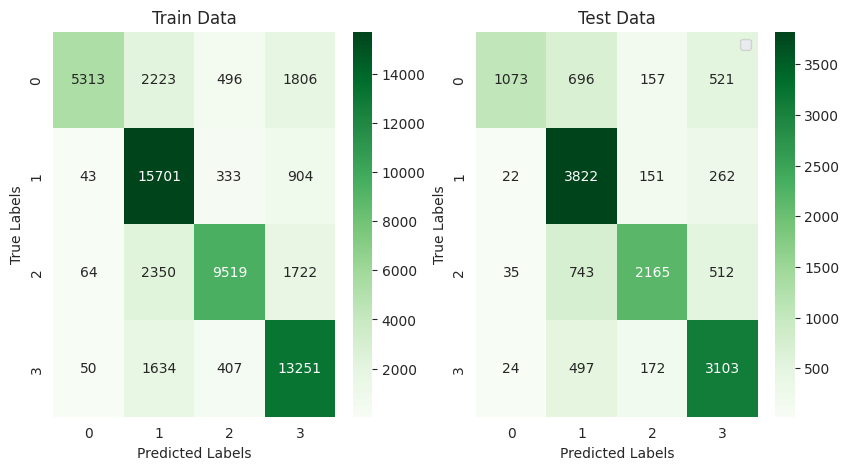

In [15]:
conf_mat(nb_pipeline, train_x_train_processed, test_x_test_processed)